# Project 1: Urban/ Spatial Data Science - FYP 2021
## Road Collision Analysis of Leeds (UK) 
---
### Group 9: Aidan Stocks, Christian Margo Hansen, Jonas-Mika Senghaas, Malthe Pabst, Rasmus Bondo Hansen
Submission: 25.02.2021 / Last Modified: 24.02.2021

---

This notebook contains the step-by-step data science process performed on the `Road Safety Data (UK)` from 2019. The goal was to inform the government of **Leeds** (Group 9 Focus) about traffic fatalities and injuries, to derive a future urban transport plan.

The raw datasets was given by the course mananger. The datasets were downloaded from the following link on Jan 4th: https://data.gov.uk/dataset/road-accidents-safety-data. That page was updated afterwards (Jan 8th). Therefore local and online data may be inconsistent.

### Introduction
Experience shows that informed policy-making often translates into good policy-making. Especially for enhancing road safety, the use of data is critical to sustainably improve a city's urban mobility concept and reduce the number of casualties on the streets. In this notebook we will develop the code that was used to analyse the Road Safety in Leeds based on the extensive data that has been collected UK-wide in 2019.
The focus of this project will be to make Leeds a bike-safer city. 

Leeds is the largest city in the county of West Yorkshire, England and the most populous in the Yorkshire and Humber region with roughly 800.000 inhabitants (2019, from *Eurostat*). Leeds' transport system is dominated by cars and it is currently the 9th most congested UK city. There have long been plans for a public transport network in Leeds, yet as of 2020, none have come to realisation, leaving Leeds' mobility landscape highly car-dominated.

# Required Libraries
---
Throughout the project, we will use a range of both built-in and external Python Libraries. This notebook will only run if all libraries and modules are correctly installed on your local machines. 
To install missing packages use `pip install <package_name>` (PIP (Python Package Index) is the central package management system, read more [here](https://pypi.org/project/pip/)). 

In case you desire further information about the used packages, click the following links to find detailled documentations:
- [Pandas Homepage](https://pandas.pydata.org/)
- [Numpy Homepage](https://numpy.org/)
- [Matplotlib Homepage](https://matplotlib.org/stable/index.html)
- [Seaborn Homepage](https://seaborn.pydata.org/)
- [Folium Documentation](https://python-visualization.github.io/folium/)
- [Scipy Homepage](https://www.scipy.org/)
- [Textwrap Documentation](https://docs.python.org/3/library/textwrap.html)

In [1]:
import pandas as pd                                    # provides major datastructure pd.DataFrame() to store the datasets
import numpy as np                                     # used for numerical calculations and fast array manipulations
import matplotlib                                      # visualisation of data
import matplotlib.pyplot as plt                        # visualisation of data
import seaborn as sns                                  # plotting categorical vs. numerical variables
import folium                                          # spatial visualisation
from folium.plugins import HeatMap, MarkerCluster      # spatial visualisation
from scipy.stats import chi2_contingency               # chi2 statistical association test
import json                                            # data transfer to json format
import os                                              # automates saving of export files (figures, summaries, ...)
import random                                          # randomness in coloring of plots
import textwrap                                        # prettify axis labelling

In [2]:
random.seed(10) # we set the seed to get reproducable results

# Constants
---
To enhance the readibilty, as well as to decrease the maintenance effort, it is useful for bigger projects to define contants that need to be accessed globally throughout the whole notebook in advance. 
The following cell contains all of those global constant. By convention, we write them in caps (https://www.python.org/dev/peps/pep-0008/#constants)

In [3]:
# path lookup dictionary to store the relative paths from the directory containing the jupyter notebooks to important directories in the project
PATH = {}
PATH["data_raw"] = "../data/raw/"
PATH["data_interim"] = "../data/interim/"
PATH["data_processed"] = "../data/processed/"
PATH["data_external"] = "../data/external/"
PATH["references"] = "../data/references/"
PATH['reports'] = {}
PATH['reports']['leeds'] = '../reports/leeds/'
PATH['reports']['bikes'] = '../reports/bikes/'
PATH['reports']['external'] = '../reports/external/'
PATH['accidents'] = 'accidents/'
PATH['casualties'] = 'casualties/'
PATH['vehicles'] = 'vehicles/'


# filename lookup dictionary storing the most relevant filenames
FILENAME = {}
FILENAME['accidents'] = 'Road Safety Data - Accidents 2019.csv'
FILENAME['casualties'] = 'Road Safety Data - Casualties 2019.csv'
FILENAME['vehicles'] = 'Road Safety Data- Vehicles 2019.csv' # the original dataset has a small typing mistake
FILENAME['variable_lookup'] = 'variable lookup.xls'
FILENAME['road_flow'] = 'dft_rawcount_local_authority_id_63.csv'

# list of internal names for datasets (used to easily iterate over them)
TABLENAMES = ["accidents", "casualties", "vehicles"]

# defining three dictionaries to store data. each dictionary will reference a pandas dataframe to a string-representation as a key.
DATA_RAW = {}
DATA_LEEDS = {}
DATA_EXTERNAL = {}
DATA_LEEDS_BIKES = {}


# for automatic labelling of the plots, we make use of an external excel-sheet that was provided with the data. we will read in the lookup of the variables into the following dictionary
VARIABLE_LOOKUP = {}

# automising all plots requires a lot of additional information (ie. what plot-type to use on the different variables, whether or not we need a fivenumber-summary, etc.). this information is stored in the summary dictionary
SUMMARY = {}
SUMMARY_BIKES = {}

# Loading, Inspection and Processing of Datasets (TASK 0)
---
Every data analysis, requires a dataset. Therefore the first step of every data science project is to load in the data that was provided and on which the data analysis should be based.

## Loading in the Datasets
---
Every data analysis, requires a dataset. Therefore the first step of every data science project is to load in the data that was provided and on which the data analysis should be based.
We conveniently load in all three datasets into an individual Pandas `DataFrame` using the built-in pandas method `pd.read_csv()` ([Documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)). We store those in our `DATA_RAW' dictionary in the corresponding keys.

In [4]:
# load all three datasets using pandas into the predefined dictionary 'DATA_RAW' where the key corresponds to the internal dataset name
for dataset in TABLENAMES:
    DATA_RAW[dataset] = pd.read_csv(PATH['data_raw'] + FILENAME[dataset])

## Inspection of Datasets
---
We can now have a look at our three dataset to get a good first impression for what kind of data we are dealing with. We start by reporting the number of records and fields/  variables in each of the datasets by using the `shape` property of the Pandas `DataFrame`. 
We then continue to have an actual look into the data. Similiar to the `head` command in terminal, we can use the method `head()` onto our `DataFrames`, which outputs a nice inline represesntation of the first five data records of the dataset.

### Size (Number of Records and Fields)

In [5]:
for dataset in TABLENAMES:
    print(f"{dataset.capitalize()}: {DATA_RAW[dataset].shape}")

Accidents: (117536, 32)
Casualties: (153158, 16)
Vehicles: (216381, 23)


### Peek into Datasets (Describing Attributes)

In [6]:
DATA_RAW['accidents'].head()

Accident_Index  Location_Easting_OSGR  Location_Northing_OSGR  Longitude  \
0  2019010128300               528218.0                180407.0  -0.153842   
1  2019010152270               530219.0                172463.0  -0.127949   
2  2019010155191               530222.0                182543.0  -0.124193   
3  2019010155192               525531.0                184605.0  -0.191044   
4  2019010155194               524920.0                184004.0  -0.200064   

    Latitude  Police_Force  Accident_Severity  Number_of_Vehicles  \
0  51.508057             1                  3                   2   
1  51.436208             1                  3                   2   
2  51.526795             1                  3                   2   
3  51.546387             1                  2                   1   
4  51.541121             1                  3                   2   

   Number_of_Casualties        Date  ...  Pedestrian_Crossing-Human_Control  \
0                     3  18/02/2019  ...                                  0   
1                     1  15/01/2019  ...                                 -1   
2                     1  01/01/2019  ...                                  0   
3                     1  01/01/2019  ...                                  0   
4                     2  01/01/2019  ...                                  0   

  Pedestrian_Crossing-Physical_Facilities  Light_Conditions  \
0                                       5                 1   
1                                      -1                 4   
2                                       0                 4   
3                                       0                 4   
4                                       0                 4   

  Weather_Conditions  Road_Surface_Conditions  Special_Conditions_at_Site  \
0                  1                        1                           0   
1                  1                        1                           0   
2                  1                        1                           0   
3                  1                        1                           0   
4                  1                        1                           0   

   Carriageway_Hazards  Urban_or_Rural_Area  \
0                    0                    1   
1                    0                    1   
2                    0                    1   
3                    0                    1   
4                    0                    1   

   Did_Police_Officer_Attend_Scene_of_Accident  LSOA_of_Accident_Location  
0                                            3                  E01004762  
1                                            3                  E01003117  
2                                            1                  E01000943  
3                                            1                  E01000973  
4                                            1                  E01000546  

[5 rows x 32 columns]

We see, that the main dataset `accidents` stores all recorded accidents in 2019. It consist of 117.536 rows, corresponding to single reported accidents, that is identified with a unique index (in the first column). Each accident is descibed via 31 descriptive variables, providing more detailed information about the accident. 
The following overview classifies all 32 variables in the dataset. It is important to differentiate the variables as their type determines how we will treat them in the further analysis:

>**Categorical Attributes**
>> `Accident_Severity (6)`, `Number_of_Vehicles (7)`, `Number_of_Casualties (8)`, `1st_Road_Class (14)`, `2st_Road_Number (15)`, `Road_Type (16)`, `Speed_limit (17)`, `Junction_Detail (18)`, `Junction_Control (19)`, `2nd_Road_Class (20)`, `2nd_Road_Number (21)`, `Pedestrian_Crossing-Human_Control (22)`, `Pedestrian_Crossing-Physical_Facilities (23)`, `Light_Conditions (24)`, `Weather_Conditions (25)`, `Road_Surface_Conditions (26)`, `Special_Conditions_at_Site (27)`, `Carriageway_Hazards (28)`, `Urban_or_Rural_Area (29)`, `Did_Police_Officer_Attend_Scene_of_Accident (30)`

>**Geographical Attributes** (There are several measures of the location of the accident)
>> `Location_Easting_OSGR (1)`, `Location_Northing_OSGR (2)`, `Longitude (3)`, `Latitude (4)`, `Police Force (5)`, `Local_Authority_(District) (12)`, `Local_Authority_(Highway) (13)`, `LSOA_of_Accident_Location (31)`

>**Time Attributes** 
>> `Date (9)`, `Time (11)`, `Day_of_Week (10)`

>**Relational Attributes**
>> `Accident_Index (0)`

In [7]:
DATA_RAW['casualties'].head()

Accident_Index  Vehicle_Reference  Casualty_Reference  Casualty_Class  \
0  2019010128300                  1                   1               1   
1  2019010128300                  1                   2               2   
2  2019010128300                  1                   3               2   
3  2019010152270                  1                   1               1   
4  2019010155191                  2                   1               2   

   Sex_of_Casualty  Age_of_Casualty  Age_Band_of_Casualty  Casualty_Severity  \
0                1               58                     9                  3   
1                2               -1                    -1                  3   
2                2               -1                    -1                  3   
3                2               24                     5                  3   
4                2               21                     5                  3   

   Pedestrian_Location  Pedestrian_Movement  Car_Passenger  \
0                    0                    0              0   
1                    0                    0              1   
2                    0                    0              2   
3                    0                    0              0   
4                    0                    0              0   

   Bus_or_Coach_Passenger  Pedestrian_Road_Maintenance_Worker  Casualty_Type  \
0                       0                                   0              9   
1                       0                                   0              9   
2                       0                                   0              9   
3                       0                                   0              9   
4                       0                                   0              1   

   Casualty_Home_Area_Type  Casualty_IMD_Decile  
0                        1                    2  
1                        1                    5  
2                        1                    5  
3                        1                    3  
4                        1                    1

We see, that the sub-dataset `casualties` provides more detailed information about the casualties of all accidents. It consist of 153.158 columns (which leads to 153.158 records on casualties) and has 16 columns providing more detailed information about the casualty. Again, we inspect all column attributes to get a feel for the information the dataset stores. We can classify as follows:
>**Categorical Attributes**
>> `Casualty_Class (4)`, `Sex_of_Casualty (5)`, `Age_Band_of_Casualty (7)`, `Casualty_Severity (8)`, `Pedestrian_Location (9)`, `Car_Passenger (10)`, `Bus_or_Coach_Passenger (11)`, `Pedstrian_Road_Maintenace_Worker (12)`, `Casualty_Type (13)`, `Casualty_Home_Area_Type (14)`, `Casualy_IMD_Decile (15)`

>**Numerical Attributes**
>> `Age_of_Casualty (6)`

>**Relational Attributes**
>> `Accident_Index (0)`, `Vehicle_Reference (1)`, `Casualty_Refernce (2)`, 

In [8]:
DATA_RAW['vehicles'].head()

Accident_Index  Vehicle_Reference  Vehicle_Type  Towing_and_Articulation  \
0  2019010128300                  1             9                        0   
1  2019010128300                  2             9                        0   
2  2019010152270                  1             9                        0   
3  2019010152270                  2             9                        0   
4  2019010155191                  1             9                        0   

   Vehicle_Manoeuvre  Vehicle_Location-Restricted_Lane  Junction_Location  \
0                 -1                                -1                 -1   
1                 -1                                -1                 -1   
2                 18                                -1                  0   
3                 18                                -1                  0   
4                  3                                 0                  1   

   Skidding_and_Overturning  Hit_Object_in_Carriageway  \
0                        -1                         -1   
1                        -1                         -1   
2                        -1                         -1   
3                        -1                         -1   
4                         0                          0   

   Vehicle_Leaving_Carriageway  ...  Journey_Purpose_of_Driver  Sex_of_Driver  \
0                           -1  ...                          6              1   
1                           -1  ...                          6              3   
2                           -1  ...                          6              2   
3                           -1  ...                          6              3   
4                            0  ...                          6              1   

   Age_of_Driver  Age_Band_of_Driver  Engine_Capacity_(CC)  Propulsion_Code  \
0             58                   9                    -1               -1   
1             -1                  -1                    -1               -1   
2             24                   5                    -1               -1   
3             -1                  -1                    -1               -1   
4             45                   7                    -1               -1   

   Age_of_Vehicle  Driver_IMD_Decile  Driver_Home_Area_Type  \
0              -1                  2                      1   
1              -1                  2                      1   
2              -1                  3                      1   
3              -1                  6                      1   
4              -1                  4                      1   

   Vehicle_IMD_Decile  
0                   2  
1                   2  
2                   3  
3                   6  
4                   4  

[5 rows x 23 columns]

We see, that the sub-dataset `vehicles` provides more detailed information about the vehicles of all accidents. It consist of 216.381 columns (which leads to 216.381 records on casualties) and has 16 columns providing more detailed information about the casualty. Again, we inspect all column attributes to get a feel for the information the dataset stores. We can classify as follows:
>**Categorical Attributes**
>> `Vehicle_Type (2)`, `Towing_and_Articulation (3)`, `Vehicle_Manoeuvre (4)`, `Vehicle_Location_Restricted_Lane (5)`, `Junction_Location (6)`, `Skidding_and_Overturning (7)`, `Hit_Object_in_Carriageway (8)`, `Vehicle_Leaving_Carriageway (9)`, `Hit_Object_off_Carriageway (10)`, `1st_Point_of_Impact (11)`, `Was_Vehicle_Left_Hand_Drive? (12)`, `Journey_Purpose_of_Driver (13)`, `Sex_of_Driver (14)`, `Age_Band_of_Driver (16)`, `Propulsion_Code (18)`, `Driver_IMD_Decile (19)`, `Driver_Home_Area_Type (20)`, `Vehicle_IMD_Decile (21)`

>**Numerical Attributes**
>> `Age_of_Casualty (6)`, `Age_of_Driver (15)`, `Engine_Capacity_(CC) (17)`, 

>**Relational Attributes**
>> `Accident_Index (0)`, `Vehicle_Reference (1)`

### Summary
We see that there exist three different datasets, that all hold information about the road collisions reported in the UK in 2019. Together the three datasets contain very rich and detailed information, allowing to theoretically reconstruct every reported accident. It is important for us to recognize that the number of records in the two subdatasets `casualties` and `vehicles` is greather than the number of records in the `accidents` dataset, since an accident involves at least one vehicle and often more than casualty.

We can link the casualties and vehicles involved in an accident by their `Accident_Index`.
Likewise, we can connect the casualties to the vehicles using the `Vehicle_Reference` attribute.

## Initial Sanity Check
---
Before continuing with the data analysis, we want to make sure that the dataset is clean. There are a plentiful of methods to check this. In the following, we will stick to the following three:
>(a) **Uniqueness of Indexes** (*Are there multiple indexes in `accidents`?*)

>(b) **Linking Behavior** (*Are there indexes in the subdatasets that do not occur in `accidents`?*)

>(c) **Missing Values** (*Are there missing values? If yes, how many and in which columns?*)

### Uniqueness of Indexes
We are first evaluating if there are mulitple indexes in the main dataset `accidents`. This is a first, very basic metric to determine whether the data in the dataset has been inputted correctly. In the case of three interlaced datasets, this check is even more important, since the `Accident_Index' property links the main dataset to the two sub-datasets.

The condition of unique indexes holds, if and only if the number unique elements in the first column (`Accident_Index`) is equal to the total number of records in the dataset. We check this condition as follows:

In [9]:
# here we check if there are mulitple indexes in the accidents dataset
DATA_RAW['accidents'].shape[0] == len(set(DATA_RAW['accidents']['Accident_Index']))

True

Perfect. There do not seem to be any multiple indexes. Each row in the dataset `accidents` seems to refer to a unique accident, that we can use reference in the two sub-datasets.

### Linking Behavior
Another index metric evolves around the `Accident_Index`es in the two sub-datasets. Ideally, no indexes that are not in the main dataset `accidents` appear in the two sub-datasets, since this would mean that there exist information on vehicles and casualties that are referenced by an unknown accident. 

We check for this condition using our own function `check_indexes_in_subset` that takes in the two columns containing the `Accident_Index`es in both the sub and main dataset and return either `None` if all indexes are correct or the number of wrong indexes if there are mistakes.

In [10]:
def check_indexes_in_subset(sub_dataset_indexes, main_dataset_indexes):
    """ 
    Helper-Function to evaluate whether there are indexes in the two linked sub datasets that do not appear in the main dataset.

    Parameters:
        sub_dataset_indexes         : pd.DataFrame
        main_dataset_indexes        : pd.DataFrame
    Return:
        #Wrong Indexes              : int (None if len() == 0)
    """
    assert len(main_dataset_indexes.shape) == 1 and len(sub_dataset_indexes.shape) == 1, 'Both function arguments must be one-dimensional'

    accidents_indexes = set(main_dataset_indexes)
    wrong_indexes = [i for i in set(sub_dataset_indexes) if i not in accidents_indexes]

    if len(wrong_indexes) == 0:
        return None
    else:
        return len(wrong_indexes)

In [11]:
# computing the wrong indexes for each sub dataset
for dataset in TABLENAMES:
    if dataset != 'accidents':
        print(f"Number of Missing Indexes in {dataset.capitalize()}: {check_indexes_in_subset(DATA_RAW[dataset]['Accident_Index'], DATA_RAW['accidents']['Accident_Index'])}")

Number of Missing Indexes in Casualties: 19325
Number of Missing Indexes in Vehicles: 21498


This is rather bad. Roughly 21.500 indexes in the raw `vehicles` dataset are linking to an accident that is not registered in the `accidents` dataset. 19.300 in the `casualties` dataset link casualties to accidents that are not registered in the `accidents` dataset. 
If we observe a similar behavior for our filted dataset for Leeds, we would need to investigate how those wrong indexes can appear as they can have a major impact of the trustworthiness of the data.

### Missing Values
Lastly, we check in all columns in all datasets the number of missing values (encoded as `' '` (*empty strings*)) to see if there are missing values (empty string) to get a feeling on which columns we need to further do processing.

In [12]:
def check_columns_for_missing_values(data):
    """
    For a dataset provided as a pd.DataFrame the function returns an informative string about each column containing null values, namely the number of missing values, the column index and the variable name of the column.

    Parameters:
        data                : pd.DataFrame
    Return:
        Informative String for each column containing null values, else None
    """
    for column in range(data.shape[1]):
        if sum(data.iloc[:,column].isnull()) != 0:
            print(f'{sum(data.iloc[:,column].isnull())} ({data.columns[column]}({column}))')

In [13]:
for dataset in TABLENAMES:
    print(dataset.capitalize())
    check_columns_for_missing_values(DATA_RAW[dataset])
    print('\n')

Accidents
28 (Location_Easting_OSGR(1))
28 (Location_Northing_OSGR(2))
28 (Longitude(3))
28 (Latitude(4))
63 (Time(11))
5714 (LSOA_of_Accident_Location(31))


Casualties


Vehicles




That's not bad! There are no missing values in both sub datasets. 
It seems like in the accidents dataset, there are 28 accidents that have no information on their location. This only gets important for our analysis if one of those accidents is located in Leeds, then we would need to deal with this issue later. The LSOA Metric - which is another measure of the accident location of the accident - hasn't been registered for 5714 accidents. This is not important for our analysis, since we will use the longitude and latitude to plot the accidents' location. 
There are, however, 63 accidents for which the time of accident is not registered. If any of those accidents are located in Leeds, we have to deal with them later.

## Processing 
---
We now know a lot more about our datasets. We have inspected each dataset's size (ie. the number of records and fields), and have inspected and classified each of the attributes in the datasets. We also generally proved the dataset to be clean.

This clears the path to filter all three datasets to only hold information about the city of interest: `Leeds`. There are several ways to do this. We could ie. filter by an geographic attribue (as listed in the `Description of Attributes`). However, there is a faster way to achieve the exact same result, since the `accidents` database contains an informative attribute called `Local_Authority_(District)`. 
> The Local Authority Districts, also known as the [Districts of England](https://en.wikipedia.org/wiki/Districts_of_England) is a subnational division of the UK into districts, each identified with a unique number. Learn more about the clustering of the country [here](https://en.wikipedia.org/wiki/Subdivisions_of_England). Note, that the ie. the attribute LSOA Location is another metric to geographically identify places in the UK, but in a more precise fashion. For the purpose of filtering for a whole city as Leeds, we however don't need this level of precision, but can make use of the fact that Leeds is a local authority district. 

From the `variable lookup.xls` sheet (which contains information about the categorical variables in all three datasets), we learn that the code `204` relates to `Leeds`. 
With this knowledge we can conveniently filter the main dataset `accidents` for `Leeds`.

In [14]:
DATA_LEEDS["accidents"] = DATA_RAW['accidents'][DATA_RAW['accidents']['Local_Authority_(District)'] == 204]

However, the two sub-datasets cannont be identified by the `Local_Authority_(District)`, since they both do not contain this attribute. 
Therefore, we need to filter for all unique accidents that occurred in Leeds and extract the `Accident Indexes`. With this relational attribute - a list of accident indexes in Leeds, we can extract the vehicles and casualties related to these Leeds accidents. but need to be filtered through the unique accident indexes that we can obtain from our filtered dataframe of accidents in 'Leeds'. We obtain a list of all accident indexes of the accidents that occured in Leeds and use this index list to filter both the 'vehicles.csv' and 'casualties.csv' datasets.
Therefore, we need to filter for all unique accidents that occurred in Leeds and extract the `Accident Indexes`. With this relational attribute - a list of accident indexes in Leeds, we can extract the vehicles and casualties related to these Leeds accidents. 

We do this conveniently with Pandas `.isin()` method on a dataframe to create a mask that filter out all accident indexes not related to Leeds. 

In [15]:
leeds_indexes = list(DATA_LEEDS['accidents']['Accident_Index']) # we dont need to set() this because we know that all indexes are unique

In [16]:
DATA_LEEDS["casualties"] = DATA_RAW['casualties'][DATA_RAW['casualties']['Accident_Index'].isin(leeds_indexes)]
DATA_LEEDS["vehicles"] = DATA_RAW['vehicles'][DATA_RAW['vehicles']['Accident_Index'].isin(leeds_indexes)]

### Inspection
---
With our newly filtered datasets, we have reduced the number of records about accidents, casualties and vehicles in the datasets `accidents`, `casualties` and `vehicles`, respectively. To see, with what kind of data we are dealing now, it makes to recompute the size of each of the datasets. However, our analysis of the column attributes still holds, since we have only filtered across `axis=0` (the rows), while we left the attributes untouched. 

Again, we report the number of records and fields/ variables in each of the datasets by using the `shape` property of the Pandas `DataFrame`. 

In [17]:
for dataset in TABLENAMES:
    print(f"{dataset.capitalize()}: {DATA_LEEDS[dataset].shape}")

Accidents: (1451, 32)
Casualties: (1908, 16)
Vehicles: (2688, 23)


The datasets are tremendously reduced. From 117.536 reported accidents in the whole of UK, 1.451 occurred in Leeds. In those 1.451 accidents, 1.908 were affected and 2.688 vehicles were involved.

### Saving Filtered Data
---
After having filtered the raw datasets into a filted one, that only contains records about accidents located in Leeds, we want to save this interims version of the data as a `csv` into an interim folder. 

In [18]:
def save_csv(data, path, filename, index=False, force=True):
    """
    Helper-Function to export pandas DataFrames into `csv` format using pandas built-in method `to_csv()`. The function provides functionality to force the creation of the path if not previously located in the file structure.

    Parameters:
        data                : pd.DataFrame
        path                : str (relative path from directory of execution file)
        filename            : str (descriptive filename (NOTE: without `.csv` file extension))
        index               : boolean (Specifies saving process in pandas.to_csv(). For more information check out the documentation of `to_csv()`)
        force               : boolean (True for automatic path creation using `os`)
    Return:
        None
    """
    if force:
        try: os.makedirs(path)
        except: None
    data.to_csv(f"{path}{filename}.csv", index=index)

In [19]:
for dataset in TABLENAMES:
    save_csv(DATA_LEEDS[dataset], path=PATH['data_interim'], filename=FILENAME[dataset][:-4], index=False) 

### Sanity Check for Leeds
--- 
With the filtered dataset, we want to repeat our initial sanity checks. This is necessary to know, at which point we need to further process the dataset. We check for the following (identical) conditions:
>(a) **Uniqueness of Indexes** (*Are there multiple indexes in `accidents`?*)

>(b) **Linking Behavior** (*Are there indexes in the subdatasets that do not occur in `accidents`?*)

>(c) **Missing Values** (*Are there missing values? If yes, how many and in which columns?*)

*For more detailed information about the functions used, revisit the section `Initial Sanity Check` or type `?<function_name>` in an individual cell to obtain a small, but informative description (docstring) about each function.*

### Uniqueness of Indexes

In [20]:
DATA_LEEDS['accidents'].shape[0] == len(set(DATA_LEEDS['accidents']['Accident_Index']))

True

### Linking Behavior

In [21]:
for dataset in TABLENAMES:
    if dataset != 'accidents':
        print(f"#Missing indexes in {dataset.capitalize()}: {check_indexes_in_subset(DATA_LEEDS[dataset]['Accident_Index'], DATA_LEEDS['accidents']['Accident_Index'])}")

#Missing indexes in Casualties: None
#Missing indexes in Vehicles: None


### Missing Values

In [22]:
for dataset in TABLENAMES:
    print(dataset.capitalize())
    check_columns_for_missing_values(DATA_LEEDS[dataset])
    print('\n')

Accidents
11 (Time(11))


Casualties


Vehicles




Perfect. None of the sanity checks report any problems on our dataset. At this point we could export the dataset and start analysing the data. However, we are making some adjustments in the below section to make our analysis easier.

## Process Data
---
Luckily, the data is already quite clean. Except for 11 out of the total of 1.451 accidents, that did not register the time of the accident, all records in all three datasets are complete. Furthermore, the linking behavior between the three datasets seems legit. 
Before starting our analysis, we want to make slight changes to our data, in order to have an easier life later in the analysis.

### `Accidents`: Time (*Column: 11*)
Our sanity check on the `Leeds` data has reported 11 missing time values. In order to not crash due to weird behaviors of empty strings, we want to clean this now. Therefore we change all empty strings to the string `-1`. This behavior is chosen by convention and is also the standard for the given dataset, as can be observed in the `variable lookup.cls`, where `Missing Values`/`N/A` are identified as `-1`.
Since we later also want to report the distributin of accident frequency during different times of the day, we slice the `Time`-String, such that it only holds the hour of the accident. This level of detail is sufficient for our analysis and simplifies the further process.

The following block of code implements the above described behavior:

In [23]:
time = np.array(DATA_LEEDS['accidents']['Time'])
for i in range(len(time)):
    try: 
        time[i] = int(time[i][:2])
    except:
        time[i] = -1

DATA_LEEDS['accidents']['Time'] = time

### `Accidents`: Date (*Column: 10*)
To make meaningful plots, we also want to adjust the data in the `Date` column in the `accidents` dataset. The column gives dates in the format `DD/MM/YYYY`. Since all accidents report accidents from 2019, we can neglect this parameter. Furthermore, the specific day is a too specific time frame to be meaningful in an analysis. We there slice the `Date`-String, such that it only holds the month, in which the accident occurred. This level of detail is sufficient for our analysis and simplifies the further process.

In [24]:
date = np.array(DATA_LEEDS['accidents']['Date'])

for i in range(len(date)):
    date[i] = int(date[i][3:5])

DATA_LEEDS['accidents']['Date'] = date

### `Accidents`: 2nd Road Class (*Column: 20*)
Inspecting both the data and the variable lookup, we noticed a minor - but not unimportant - discrepancy in the 20th column of the `accidents` dataset. From the variable lookup, the following lookup is expected {0: Not at junction or within 20 metres, ...}. However, in the dataset, there do not appear any `0`, but a lot of `-1` (which does not appear in the variable lookup for this column). It is therefore reasonable to argue that this is a mistake in the variable lookup (and could thusly be easily fixed, by exchanging the `0` for a `-1`). In this example however, we decided to change all `-1` to `0` in the column, in order to make the jupyter work on the original files given.

The following block of code implements this change.

In [25]:
second_road_class = np.array(DATA_LEEDS['accidents']['2nd_Road_Class'])

for i in range(len(second_road_class)):
    if second_road_class[i] == -1:
        second_road_class[i] = 0

DATA_LEEDS['accidents']['2nd_Road_Class'] = second_road_class

## Export Processed Datasets
--- 
Finally, we export the processed datasets into a new subfolder. From now on, all Jupyter Notebooks will work with those processed datasets.

In [26]:
for dataset in TABLENAMES:
    save_csv(DATA_LEEDS[dataset], path=PATH['data_processed'], filename=FILENAME[dataset][:-4], index=False)

# Single Variable Analysis (TASK 1)
---
We have obtained filtered and processed datasets from TASK 0. We will now turn our focus to analysing each attribute in each of the datasets both in a numerical summary (ie. through the number of uniques, counts of uniques or a five-number summary, where it makes sense) and visual representation. Depending on the type of the variable, there arouse different preferred ways of visual repsentation, to get a visual feeling for the data we are dealing with. 
> `Barplot` (*Categorical Variables*)
>> We usually want to plot categorical variables in a bar plot, where the x-axis is labelled with the unique values measured in the specific column and the y-axis represents the number of occurences of each unique value. An example of a bar plot in this project is ie. the Number of Accidents per Week Day.

> `Histogram` (*Numerical Variables*)
>> Most numerical variables (especially those with a wide range), are plotted in a histogram (which accounts for the fact that numerical variables are contiuous). An example of a histogram is ie. the Age Distribution of Casualties involved in an Accident.

> `None` (*Others*)
>> For some variables it doesn't make sense to plot them, ie. geographical (`Longitude`, ...) or relatinonal attributes (`Accident_Index`, ...).

## Importing Variable Lookup 
---
Before calculating the numerical summaries for each column and visualising them, we import the `variable lookup.xls` from the given references. The Excel-Sheet encodes which numerical value corresponds to which meaning for each column. This is essential for the dataset to be meaningful (otherwise it is just a bunch of useless numbers). Likewise, our plots should contain the human-readable interpretation of the variables, not the numerical values, to make them readable to everyone (even for those not having the `variable lookup`).

In order to save a lot of work by manually copy/pasting from the Excel-Sheet, we use pandas built-in method `pd.ExcelFile` that instantiates a `ExcelFile` object, containing a lot of useful functionality to conveniently read in the lookups. In the following block of code we create a dictionary, where each key corresponds to the index of the excel sheet and leads to nested dictionary that holds the correct encoding of the column obtained from the `variable lookup`

In [27]:
xls = pd.ExcelFile(PATH['references'] + FILENAME['variable_lookup']) # instatiate ExcelFile object using pandas built-in `pd.ExcelFile`

# read in excel data into python dict of dicts
excel_dict = {i: xls.parse(xls.sheet_names[i]).to_dict() for i in range(len(xls.sheet_names))}

# create convenient lookup dictionary for all excel sheets
for x in range(2, len(excel_dict)): # start from sheet with index 2 (since previous do not encode lookups, and are therefore formatted differently)
    VARIABLE_LOOKUP[x] = {} # create key-value pair with key being the index of the sheet and value an empty dictionary
    try:
        for i in range(len(excel_dict[x]['code'])):
            VARIABLE_LOOKUP[x][excel_dict[x]['code'][i]] = excel_dict[x]['label'][i] # merge `code` dict and `label` dict 
    except: # account for irregularity in the excel sheet at sheet index 6, where the column names are capitalised (unlike all other sheets)
        for i in range(len(excel_dict[x]['Code'])):
            VARIABLE_LOOKUP[x][excel_dict[x]['Code'][i]] = excel_dict[x]['Label'][i] # merge `code` dict and `label` dict 

In [28]:
# account for irregularity in excel sheet at index 36 (Vehicle Propulsion Code)
del VARIABLE_LOOKUP[36][' M']
VARIABLE_LOOKUP[36][-1] = 'Undefined'

## Initialise Summaries 
---
In order to automate the process of creating numerical summaries and appropriate visualisations for each plot, we create a central datastructure for each of the datasets, which we call `SUMMARY` (*see this in `Constants`). The `SUMMARY` datastructure is a rich datastructure defined for each dataset,which initially contains the name, label behavior (*Does the column have a Lookup?*), plotting behavior (*How do we want to plot the column?*) and information about the five-number summary (*Whether or not we want to compute a five-number summary?*). 
Later we will fill this data structure even further and use is as a basis for all our plots. 

However, the first step is to manually inspect all columns and decide on how we want to deal with them. We hardcode these observation into three individually dictionaries defined for each dataset.

In [29]:
# dictionary holding the column indexes in the specific dataset, which have a variable lookup
LABELS = {}
LABELS['accidents'] = [5, 6, 10, 12, 13, 14, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30]
LABELS['casualties'] = [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
LABELS['vehicles'] = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18]

# dictinary that for each column in each dataset specifies the type of plot to use
PLOTTING = {}
PLOTTING['accidents'] = [None, None, None, None, None, 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', None]
PLOTTING['casualties'] = [None, None, None, 'bar', 'bar', 'hist', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar',None]
PLOTTING['vehicles'] = [None, None, 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'bar', 'hist', 'bar', 'hist', 'bar', 'hist', None, 'bar', None]

# dictionary holding the column indexes in the specific dataset, for which it makes sense to compute a five-number summary
FIVENUM = {}
FIVENUM['accidents'] = [6, 7, 8, 17]
FIVENUM['casualties'] = [5]
FIVENUM['vehicles'] = [15, 17, 19]

In [30]:
def initialise_summary(dataset_name, key, summary, labels, plotting, fivenum, start_at=0):
    """
    Function to initialise the central data structure SUMMARY for some information about the dataset.

    Parameters:
        dataset_name         : str (String identifying the dataset) 
        summary              : dict (Empty dict constants where to store the data (will be stored at key `dataset_name`))
        labels               : dict (dict holding the column indexes of the dataset at key `dataset_name`)
        plotting             : dict (dict holding the plotting behavior for each column at key `dataset_name`)
        fivenum              : dict (dict holding the column indexes of the dataset at key `dataset_name`)

    Returns:
        SUMMARY['dataset_name'] = {
            0: {'Name': <col_name>, 
                'Plot': <bar, hist, None>,
                'Summary': <True/False>,
                'Map': {...} (if available)},
            1: {...}
        }
    """

    # initialise the lookup dictionary with the column name and variable type
    summary[key] = {}
    for i in range(DATA_LEEDS[dataset_name].shape[1]):
        summary[key][i] = {'Name': list(DATA_LEEDS[dataset_name])[i]}
        if plotting[i] == 'bar':
            summary[key][i].update({'Plot': 'bar'})
        elif plotting[i] == 'hist':
            summary[key][i].update({'Plot': 'hist'})
        else: summary[key][i].update({'Plot': None})

        if i in fivenum:
            summary[key][i].update({'Summary': True})
        else: summary[key][i].update({'Summary': False})

    # add the maps to the lookup dictionary
    categorical_counter = 0
    for column in labels:
        if dataset_name == 'casualties':
            if categorical_counter == 2: 
                summary[key][column]['Map'] = VARIABLE_LOOKUP[35]
                categorical_counter += 1
                continue
            if categorical_counter == 10:
                summary[key][column]['Map'] = VARIABLE_LOOKUP[48]
                categorical_counter += 1
                continue
            if categorical_counter == 11:
                summary[key][column]['Map'] = VARIABLE_LOOKUP[47]
                categorical_counter += 1
                continue
        
        summary[key][column]['Map'] = VARIABLE_LOOKUP[start_at+categorical_counter]
        categorical_counter += 1

In [31]:
for i, start_at in zip(list(range(3)), [2, 37, 22]): # start_at corresponds to sheet indexes at which it switches to new dataset
    initialise_summary(TABLENAMES[i], TABLENAMES[i], SUMMARY, LABELS[TABLENAMES[i]], PLOTTING[TABLENAMES[i]], FIVENUM[TABLENAMES[i]], start_at=start_at)

We also want to have a nice mapping for the time, date and the number of vehicles and casualties. We do this manually, since it is not defined in the given variable lookup excel.

In [32]:
# time mapping
SUMMARY['accidents'][11]['Map'] = {i: f"{i}-{i+1}" for i in range(24)}
SUMMARY['accidents'][11]['Map'][-1] = 'N/A'

# date mapping
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
SUMMARY['accidents'][9]['Map'] = {i+1: months[i] for i in range(12)}

# no. casualties and vehicles
SUMMARY['accidents'][7]['Map'] = {i: i for i in np.unique(DATA_LEEDS['accidents']['Number_of_Vehicles'])}
SUMMARY['accidents'][8]['Map'] = {i: i for i in np.unique(DATA_LEEDS['accidents']['Number_of_Casualties'])}

## Numerical Analysis
---
We have defined our central datastructure `SUMMARY` that currenlty contains information on how to process each column in each dataset. Given the column index as a key it stores...
> ...the name of the attribute at `['Name']`

> ...the way we would like to plot the attribute at `['Plot']`

> ...whether or not we need a five-number summary at `['Summary']`

> ...the mapping from the variable lookup (if there exist one) at `['Map']`

However, the dictionary does not yet contain any data or actual summaries. We will change this in the following section. With the help of the small helper-function `get_uniques_and_counts` and `get_fivenumsummary`, we can easily iterate over the summaries of each dataset in `compute_numerical_summary` and depending on the specified properties of each column, make computations. 

In [33]:
def get_uniques_and_counts(data):
    """
    Helper-Function to return the uniques and their corresponding counts for a one-dimensional array/ vector or list of numbers using numpy's              'np.unique' method. 

    Parameter: 
        data        : pd.DataFrame / np.array (one-dimensional)
    Return:
        uniques     : np.array (one-dimensional)
        counts      : np.array (one-dimensional)
    """
    assert len(data.shape) == 1, 'Data must be one-dimensional.'
    uniques, counts = np.unique(data, return_counts=True)

    return uniques, counts

In [34]:
def get_fivenumsummary(data):
    """
    Helper-Function to return a five-number summary for a one dimensional array/ dataframe (column) using numpy's `np.percentile` function. This function restricts the input to only values greater than or equal to 0, in order to disregard missing values (`-1`)

    Parameter: 
        data                : pd.DataFrame / np.array (one-dimensional)
    Return:
        np.percentile()     : np.array (one-dimensional)
    """
    try: fivenum = np.percentile(data[data >= 0], [0, 25, 50, 75, 100])
    except: fivenum = None
    return fivenum

In [35]:
def compute_numerical_summary(summary, data): #
    for column in range(len(summary)):
        # compute number of uniques and counts for every column
        uniques, counts = get_uniques_and_counts(data.iloc[:,column])
        summary[column]['No_Uniques'] = len(uniques) # attach number of uniques for each column to SUMMARY
            
        # compute five-number summary if specified
        if summary[column]['Summary'] == True:
            summary[column]['Five_Number_Summary'] = get_fivenumsummary(data.iloc[:,column])

        # attach uniques/ counts as dictionary for all variables that we want to plot as a barplot
        if summary[column]['Plot'] == 'bar': 
            if len(uniques) < 100:
                summary[column]['Uniques'] = {uniques[i]: counts[i] for i in range(len(uniques))}
        
        # attach data of the column for all variables that we want to plot as a histogram or need a five-number-summary
        if summary[column]['Plot'] == 'hist' or summary[column]['Summary'] == True:
            summary[column]['Data'] = np.array(data[summary[column]['Name']])

In [36]:
for dataset in TABLENAMES:
    compute_numerical_summary(SUMMARY[dataset], DATA_LEEDS[dataset])

Great! For each dataset, we have computed the relevant data in each column. Depending on the properties, the following properties have been added...

> ...the number of uniques values at `['No_Uniques']` for all columns (independent of their type)

> ...a five-number summary at `['Five_Number_Summary']` if it is meaningful to compute a five-number summary for the column (ie. `['Summary']`==True)

> ...a dictionary of uniques and counts at `['Uniques']` if the column should be visualised as a barplot (ie. `['Plot']`=='bar')

> ...a data property storing all values in the column at `['Data']` if the column should be visualised as a histogram or barplot (ie. `['Plot']`=='hist')

### Saving Numerical Reports
We have now computed all relevant data necessary to plot our data. Before doing so, we want to save the numerical summaries using our function `save_numerical_report`. The function takes in the `SUMMARY` datastructures and saves it either as a `csv` or `json` into the specified path for further inspection and external reports. The ouput shows into which directory the files were saved.

In [37]:
def save_numerical_report(summary, path, filename, force=True, save_to='csv'):
    """
    Function to save the SUMMARY['dataset_name`] dictionary into either `csv` or `json` format for further use or extensive inspection by specifying a having path and filename. 

    Parameters:
        summary         : dict (SUMMARY dict holding information about each column of the dataset)
        path            : str (Relative path to location of saving)
        filename        : str (Filename (without suffix `.csv` or `.json`))
        save_to         : str (either `csv` or `json`)
    Return: None 
    """
    summary_dataframe = pd.DataFrame(summary)
    
    if force:
        try: os.makedirs(path)
        except: None

    if save_to == 'csv': summary_dataframe.to_csv(f'{path}/summary_{filename}.csv')
    elif save_to == 'json': summary_dataframe.to_json(f'{path}/summary_{filename}.json')
    else: raise NameError(f"'{save_to}' not defined. Try saving to 'csv' or 'json' format.")
    print(f"Saved: {filename}.{save_to} to {path}")

In [38]:
for dataset in TABLENAMES:
    save_numerical_report(SUMMARY[dataset], path=PATH['reports']['leeds'] + PATH[dataset] + 'numerical_summary/', filename=dataset,save_to='csv')
    save_numerical_report(SUMMARY[dataset], path=PATH['reports']['leeds'] + PATH[dataset] + 'numerical_summary/', filename=dataset,save_to='json')

Saved: accidents.csv to ../reports/leeds/accidents/numerical_summary/
Saved: accidents.json to ../reports/leeds/accidents/numerical_summary/
Saved: casualties.csv to ../reports/leeds/casualties/numerical_summary/
Saved: casualties.json to ../reports/leeds/casualties/numerical_summary/
Saved: vehicles.csv to ../reports/leeds/vehicles/numerical_summary/
Saved: vehicles.json to ../reports/leeds/vehicles/numerical_summary/


## Visualisation
---
An essential step of each data exploration is to visualise our data. Only this makes the abstract numbers and characters meaningful.

We are therefore visualising the results of the single variable analysis in this section using the data structure `SUMMARY` we have step-by-step developed throughout the project. Depending on the properties of the attribute to plot, there arise three types of visualisatin:
> `Barplot`: The standard way of representing `categorical variables` using rectangular bars with heights and widths ([More information](https://en.wikipedia.org/wiki/Bar_chart))

> `Histogram`: A histogram is an approximate representation of the distribution of numerical data ([More information](https://en.wikipedia.org/wiki/Histogram))

> `Boxplot`: Boxplots are an important statistical tool to represent five-number summaries of numerical data visually ([More information](https://en.wikipedia.org/wiki/Box_plot))

To efficiently plot everything, we defined three unique functions `barplot`, `histogram` and `boxplot` that all take in the `SUMMARY` data structure as their main argument and 'intelligently' combine all informatation we have previously gathered to give a nice visualisation of the data.
We use the function `save_all_single_variable_analysis` that depends on `save_figure` to iterate over all columns and for each attributes computes and saves the correct plot in the correct directory. 

In [39]:
def barplot(summary, dimensions=(32,18), keep_missing_values=True):
    """
    Function to create barplot based on the SUMMARY data structure. Displays inline in Jupyter when called without additional parameters. Use %%capture to prevent inline plotting

    Parameter:
        summary             : dict (central data structure to hold information about all columns in dataset)
        dimensions          : tuple (specify size of plotted figure)
        keep_missing_values : boolean (plot with or without missing values)
    Return: 
        fig                 : matplotlib.Figure 
    """
    # create figure and axes (with padding for better exporting)
    fig = plt.figure(figsize=dimensions)
    ax = fig.add_axes([.15,.15,.7,.7]) # [left, bottom, width, height]
    
    # defining variables depending on missing_values variable
    if keep_missing_values:
        x = list(summary['Uniques'].keys())
        y = list(summary['Uniques'].values())
        title = title = f"Distribution: {summary['Name'].replace('_', ' ')} (with missing values)"
        color = 'darkred'
        yticks = list(summary['Uniques'].keys())
    
    else: 
        if -1 in list(summary['Uniques'].keys()):
            x = list(summary['Uniques'].keys())[1:]
            y = list(summary['Uniques'].values())[1:]
            yticks = list(summary['Uniques'].keys())[1:]
        else: 
            x = list(summary['Uniques'].keys())
            y = list(summary['Uniques'].values())
            yticks = list(summary['Uniques'].keys())

        title = f"Distribution: {summary['Name'].replace('_', ' ')} (without missing values)"
        color = 'darkblue'
        
    spaced_ticks = [i for i in range(len(yticks))]
    
    # plot 
    ax.barh(spaced_ticks, y, align='center', color=color)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Number of Accidents')
    try: # account for 0% datasets
        ax.set_xlim(0, 1.15*max(y)) 
    except: None

    ax.set_yticks(spaced_ticks)
    ax.tick_params(axis='y', which='major', pad=10)
    ax.invert_yaxis()

    try: 
        y_labels = [summary['Map'][i] for i in x] # use lookup from xls 
        if summary['Name'] == 'Number_of_Vehicles' or summary['Name'] == 'Number_of_Casualties': # account for weird textwrap behavior in these cols
            ax.set_yticklabels(y_labels)
        else: ax.set_yticklabels([textwrap.fill(label, 10) for label in y_labels]) # textwrap for nicer looking labelling
    except: None # account for variables that do not have lookup mapping

    # insert counts and percentages as text next to the corresponding bars
    for x_cord, y_cord in zip(spaced_ticks,y):
        ax.text(y_cord, x_cord, f'{y_cord} ({str(100*round(y_cord/sum(y), 3))[:5]}%)' , color='black', fontweight='bold')
    plt.tight_layout()

    return fig

In [40]:
def histogram(summary, dimensions=(32,18), keep_missing_values=True):
    """
    Function to create histogram based on the SUMMARY data structure. Displays inline in Jupyter when called without additional parameters. Use %%capture to prevent inline plotting

    Parameter:
        summary             : dict (central data structure to hold information about all columns in dataset)
        dimensions          : tuple (specify size of plotted figure)
        keep_missing_values : boolean (plot with or without missing values)
    Return: 
        fig                 : matplotlib.Figure 
    """
    assert summary['Plot'] == 'hist', "This variable cannot be plotted as a histogram. Check out the 'Plot' property in SUMMARY to see how to plot this attribute."

    # create figure and axes (with padding for better exporting)
    fig = plt.figure(figsize=dimensions)
    ax = fig.add_axes([.1,.1,.8,.8])

    # defining variables depending on missing_values variable
    if keep_missing_values:
        title = f"Distribution: {summary['Name'].replace('_', ' ')} (with missing values)"
        data = summary['Data']
        color = 'darkred'

    else: 
        title = f"Distribution: {summary['Name'].replace('_', ' ')} (without missing values)"
        data = summary['Data'][(summary['Data'] != -1)] # masking out -1
        color = 'darkblue'

    # plot
    ax.hist(data, bins=50, color=color)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel('Number of Accidents')
    ax.set_xlabel('Age')

    return fig

In [41]:
def boxplot(summary, dimensions=(16,9)):
    """
    Function to create a boxplot for numerical values based on the SUMMARY data structure. Displays inline in Jupyter when called without additional parameters. Use %%capture to prevent inline plotting

    Parameter:
        summary             : dict (central data structure to hold information about all columns in dataset)
        dimensions          : tuple (specify size of plotted figure)
        keep_missing_values : boolean (plot with or without missing values)
    Return: 
        fig                 : matplotlib.Figure 
    """
    assert summary['Summary']==True, "This variable does not require a five-number summary and can therefore not be plotted as a boxplot."

    # create figure and axes (with padding for better exporting)
    fig = plt.figure(figsize=dimensions)
    ax = fig.add_axes([.1,.1,.8,.8])

    # plot
    ax.boxplot(summary['Data']);
    ax.set_title(f"Boxplot of {summary['Name'].replace('_', ' ')}", fontweight='bold')

    return fig

### Accident Frequency for different age groups

In [ ]:
accidents_per_age_band = barplot(SUMMARY['vehicles'][16],  keep_missing_values=False) # age band
accidents_per_age = histogram(SUMMARY['vehicles'][15], keep_missing_values=False) # age

### Accident Frequency for different times of the day, week and year

In [ ]:
accidents_per_hour_of_day = barplot(SUMMARY['accidents'][11], keep_missing_values=False) # time
accidents_per_day_of_week = barplot(SUMMARY['accidents'][10], keep_missing_values=False) # day of week
accidents_per_month_of_year = barplot(SUMMARY['accidents'][9], keep_missing_values=False) # date

### Accident Frequency for different Environmental Conditions

In [ ]:
accidents_by_light_condition = barplot(SUMMARY['accidents'][24], keep_missing_values=False)
accidents_by_weather_condition = barplot(SUMMARY['accidents'][25], keep_missing_values=False)
accidents_by_road_surface_conditin = barplot(SUMMARY['accidents'][26], keep_missing_values=False)

## Saving Figures
---
For our report, we want to have nice visualisations for all our figures. To achieve this, we use the helper-function `save_figure` that depends on the property `.savefig()` of `maplotlib.pyplot.Figure` objects. We call this function on all the plots of our datasets, which automatically saves all figures into the correct directories. When executed with the path specified below, the figures are in the following directory:
> `../reports/leeds/accidents/single_variable_analysis`

> `../reports/leeds/casualties/single_variable_analysis`

> `../reports/leeds/vehicles/single_variable_analysis`

**REMARK**: Be aware that the cell takes some time to compute, since it plots and saves all figures at once.

In [42]:
def save_figure(figure, path, filename, force=True, save_to='pdf'):
    """
    Function to save any matplotlib figure into a specified (relative) path and given filename. The function provides functionality to force the creation of the path if not previously located in the file structure.

    Parameters:
        figure          : plt.Figure 
        path            : str (Relative path to location of saving)
        filename        : str (Filename (without suffix `.csv` or `.json`))
        force           : boolean (Creates Path automatically if `True`, else `False`)
        save_to         : str (either `csv` or `json`)
    Return: None 
    """
    if force:
        try: os.makedirs(path)
        except: None

    figure.savefig(f'{path}/{filename}.{save_to}')
    print(f"Saved: '{filename}.{save_to}' to {path}")

In [43]:
def save_all_single_variable_analysis(summary, path, missing_values=False):
    """
    Function to save all figures from the single variable analysis automatically into a specified (relative) path. Filenames are generated automatically. Displays inline in Jupyter when called without additional parameters. Use %%capture to prevent inline plotting

    Parameter:
        summary             : dict (central data structure to hold information about all columns in dataset)
        path                : str (Relative path to location of saving)
        keep_missing_values : boolean (plot with or without missing values)
    Return: 
        fig                 : matplotlib.Figure 
    """
    for column in range(len(summary)):
        if summary[column]['Plot'] == 'bar':
            # create barplot
            fig = barplot(summary[column], keep_missing_values=missing_values)

            # set path to save to 
            if missing_values: spath = path + 'with_missing_values'
            else: spath = path + 'without_missing_values'

            # save to path
            save_figure(fig, spath, filename=f"{column}_{summary[column]['Name']}", save_to='pdf')

        elif summary[column]['Plot'] == 'hist':
            # create histogram
            fig = histogram(summary[column], keep_missing_values=missing_values)

            # set path to save to 
            if missing_values: spath = path + 'with_missing_values'
            else: spath = path + 'without_missing_values'

            save_figure(fig, spath, filename=f"{column}_{summary[column]['Name']}", save_to='pdf')

        if summary[column]['Summary']:
            # create boxplot
            fig = boxplot(summary[column])

            # set path to save to 
            spath = path + 'boxplots'
            
            save_figure(fig, spath, filename=f"{column}_{summary[column]['Name']}", save_to='pdf')

In [ ]:
%%capture 
for dataset in TABLENAMES:
    save_all_single_variable_analysis(SUMMARY[dataset], path=PATH['reports']['leeds'] + PATH[dataset] + 'single_variable_analysis/', missing_values=True)
    save_all_single_variable_analysis(SUMMARY[dataset], path=PATH['reports']['leeds'] + PATH[dataset] + 'single_variable_analysis/', missing_values=False)

# Associations (TASK 2)
---
An equally important, and perhaps more challenging, part of any data analysis is to find associations in a dataset. Especially when analysing *Road Safety* this is a key aspect of the analysis, as we can investigate which accident, casualty or vehicle attribute lead to more frequent or severe accidents. These insights, in turn, allow us to proactively counteract through political measures. 

Since our dataset is dominated by `categorical variables` (as seen in the `Initial Inspection of Datasets`), we mostly want to relate `categorical variables` to each other and the few `numerical variables` that exist there. The following methods of associating are used in the following section to investigate these associations:
> **`Categorical/ Numerical`**
>> For relating a categorical to a numerical variable we use so-called `categorical scatterplots`, which are a special kind of scatterplot which displays the distribution of a numerical variable for different attributes in the cateogrical variable. To plot these kind of plots we use our own function `categorical_scatterplot` that at its core depends on `sns.catplot` ([Documentation](https://seaborn.pydata.org/generated/seaborn.catplot.html))

> **`Categorical/ Categorical`**
>> Relating two categorical attributes to one another is slightly more difficult. To do this, we count the number of occurrences in all possible combinations of the two categorical variables and plot those in individual plots. To investigate the associativity between the two categorical variables, we use the [Pearson Chi Squared](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test) test. It is a statistical test applied to sets of categorical data to evaluate how likely it is that any observed difference between the sets arose by chance. It follows the general assumption, that we expect no change in the relative observed values if there is no association at all. 

## Picking Focus
---
In datasets as bis as the ones given, it is not meaningful to associate every attribute to every attribute. Instead, we want to investigate which attributes the most statistically associated to attributes that are a measure for the *Road Safety*.
Following this train of though, the most important metric is the `Accident Severity`, which we can find in the `accidents` dataset at column index `6`. It makes sense to investigate, which attributes results in the most severe accident (ie. is most associated to the `Accident Severity`).

## Linking Sub-Datasets
---
Since we also want to investigate, which `vehicle` and `casualty` attributes are most related to the `Accident Severity`, we need to prepare our data before actually associating. Namely: For each reported casualty (data record in `casualties`) and vehicle (data record in `vehicles`), we need to find the corresponding accident and its severity and map it to the specific casualty or vehicle. The following function `link_to_accidents` performs exactly this computation when called with `focus='Accident_Severity'`, as it returns a column vector of length of the number of vehicles/ casualty (in general: data.shape[0] (number of rows)), which contains the `Accident Severity` for each vehicle/ casualty. 

In [181]:
def link_to_accidents(data, focus):
    ans = []
    for i in range(data.shape[0]):
        index = data['Accident_Index'].iloc[i]
        mask = DATA_LEEDS['accidents']['Accident_Index'] == index
        focus_column = DATA_LEEDS['accidents'][mask][focus]
        ans.append(int(focus_column))
    return np.array(ans)

In [182]:
SEVERITY = {}
for dataset in TABLENAMES:
    SEVERITY[dataset] = link_to_accidents(DATA_LEEDS[dataset], focus='Accident_Severity')

## Categorical/ Numerical Analysis (Swarm Plots)
---

In [183]:
def categorical_scatterplot(summary_categorical, data_categorical, summary_numerical, data_numerical, _kind='svarm', _exclude=100):
    """
    Function to create a categorical scatterplot (finding an association between a numerical and cateogrical variable) using `sns.catplot`. Displays inline in Jupyter when called without additional parameters. Use %%capture to prevent inline plotting

    Parameter:
        data                                  : pd.DataFrame (central data structure to hold information about all columns in dataset)
        summary_categorical_variable          : dict (SUMMARY of specific column)
        summary_numerical_variable            : dict (SUMMARY of specific column)
        _kind                                 : str (either 'svarm' or 'violin')
        _exclude                              : int (excludes plotting of attributes from the categorical variable that occur less than the specified value)
    Return: 
        fig                                   : matplotlib.Figure 
    """
    name_categorical, name_numerical = summary_categorical['Name'], summary_numerical['Name']
    data_categorical, data_numerical = data_categorical, data_numerical
    
    data_to_plot = np.array([data_categorical, data_numerical]).T
    
    # masking
    without_missing_values = (data_to_plot[:,0] > -1) & (data_to_plot[:,1] > -1) # we first mask out all data records where either of the two observed attributes has missing values

    uniques, counts = np.unique(data_categorical, return_counts=True)
    under_100 = [uniques[i] for i in range(len(counts)) if counts[i] < _exclude] # we then also mask out "irrelevant" 
    exclude_small_values = ~np.isin(data_categorical, under_100)

    final_mask = (without_missing_values) & (exclude_small_values)
    data_to_plot = data_to_plot[final_mask]
    
    if _kind == 'svarm':
        fig = sns.catplot(x = name_categorical, y = name_numerical, data=pd.DataFrame(data_to_plot, columns=[name_categorical, name_numerical]), kind='swarm', height=8.27, aspect=16/9, legend=True);
        try:
            fig.set_xticklabels([summary_categorical['Map'][i] for i in [j for j in uniques if j not in under_100]]);
        except: None
        fig.fig.suptitle(f'Categorical Scatterplot for {name_categorical.replace("_", " ")} and {name_numerical.replace("_", " ")}', fontweight='bold')
    elif _kind == 'violin':
        fig = sns.catplot(x = name_categorical, y = name_numerical, data=pd.DataFrame(data_to_plot, columns=[name_categorical, name_numerical]), kind='violin', height=8.27, aspect=16/9, legend=True);
        try:
            fig.set_xticklabels([summary_categorical['Map'][i] for i in [j for j in uniques if j not in under_100]]);
        except: None
        fig.fig.suptitle(f'Categorical Scatterplot for {name_categorical.replace("_", " ")} and {name_numerical.replace("_", " ")}', fontweight='bold')
    else: raise NameError(f"type = '{kind}'' is not defined. Try 'svarm' or 'violin'")

    return fig;

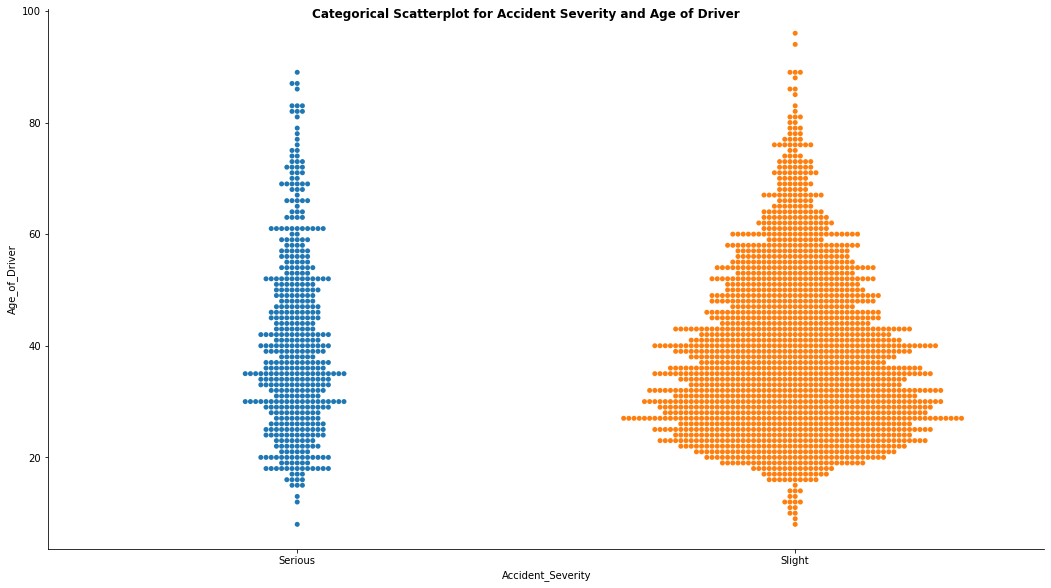

In [184]:
categorical_scatterplot(SUMMARY['accidents'][6], SEVERITY['vehicles'], SUMMARY['vehicles'][15], DATA_LEEDS['vehicles'].iloc[:,15])

In [185]:
fig, V = categorical_association_test(data, SUMMARY['accidents'][6], SEVERITY[dataset_name], summary[i], data.iloc[:,i])

NameError: name 'data' is not defined

In [200]:
def categorical_association_test(data, marker_variable_summary, marker_data, relational_variable_summary, relational_data):
    """
    Function to create an informative figure for evaluating the association of two categorical variables. Associativity Measure is based on Pearson Chi Squared Association Test using `sns.catplot`. Displays inline in Jupyter when called without additional parameters. Use %%capture to prevent inline plotting

    Parameter:
        data                                  : pd.DataFrame (central data structure to hold information about all columns in dataset)
        marker_variable_summary               : dict (SUMMARY of column for which we want to observe associativity)
        relational_variable_summary           : dict (SUMMARY of related column)
    Return: 
        fig                                   : matplotlib.Figure 
        V                                     : float (Crawer's V [Value between [0,1] indicating the associativity])
    """
    name1, name2 = marker_variable_summary['Name'], relational_variable_summary['Name']
    data1, data2 = marker_data, relational_data

    # crosstab
    observed_pd = pd.crosstab(data1, data2, rownames = [name1], colnames = [name2]).T
    observed = observed_pd.to_numpy()

    chiVal, pVal, df, expected = chi2_contingency(observed)
    chiVal, pVal, df, expected.astype(int)
    V = np.sqrt( (chiVal / observed.sum() ) / (min(observed.shape)-1) )

    fig, axes = plt.subplots(nrows=2, ncols=len(np.unique(data1)), figsize=(32, 16), constrained_layout=True)
    fig.suptitle(f"Association of {name1.replace('_', ' ')} and {name2.replace('_', ' ')} (chiVal: {round(chiVal, 2)}, pVal: {round(pVal, 2)}, V: {round(V, 2)})", fontweight='bold', fontsize=16)
    

    labels1 = [marker_variable_summary['Map'][i] for i in np.unique(data1)]
    labels2 = [relational_variable_summary['Map'][int(i)] for i in np.unique(data2)]
    x = np.array(labels2)

    for i, ax in enumerate(axes[0]):
        ax.plot(x, observed[:,i], 'ro-', label='Observed')
        ax.plot(x, expected[:,i], 'bo-', label='Expected')
        if i==0: 
            ax.set_ylabel('No. of Accidents')
            ax.legend(loc='best');
        ax.set_title(labels1[i])
        ax.set_xticks(x)

    for i, ax in enumerate(axes[1]):
        ax.plot(x, observed[:,i]/expected[:,i], 'go-')
        ax.plot(x, np.ones(x.shape), 'k:')
        
        if i==0: 
            ax.set_ylabel('Observed/Expected')
        ax.set_xticks(x)
        ax.set_xticklabels(labels2)
        fig.autofmt_xdate(rotation=45)
    
    return (fig, round(V,2))

In [204]:
def save_all_categorical_scatters(data, summary, path):
    """
    Function to save all categorical scatters for a given dataset automatically into a specified (relative) path. Filenames are generated automatically. Displays inline in Jupyter when called without additional parameters. Use %%capture to prevent inline     plotting

    Parameter:
        data                : pd.DataFrame (whole dataset)
        summary             : dict (central data structure to hold information about all columns in dataset)
        path                : str (Relative path to location of saving)
        keep_missing_values : boolean (plot with or without missing values)
    """
    for i in range(len(summary)):
        if summary[i]['Plot'] == 'hist':
                fig = categorical_scatterplot(SUMMARY['accidents'][6], SEVERITY[dataset], summary[i], data.iloc[:,i], _exclude=0, _kind='svarm') # catch errors when scatter cannot be computed

                spath = path 
                save_figure(fig, spath, filename=f"scatter_{i}_{summary[i]['Name']}", save_to='pdf')

In [205]:
def save_all_categorical_associations(data, dataset_name, summary, path):
    """
    Function to save all association plots between two categorical variables for a given dataset automatically into a specified (relative) path. Filenames are generated automatically. Displays inline in Jupyter when called without additional parameters. Use %%capture to prevent inline     plotting

    Parameter:
        data                : pd.DataFrame (whole dataset)
        summary             : dict (central data structure to hold information about all columns in dataset)
        path                : str (Relative path to location of saving)
        dataset_name        : str (Identifier for dataset)
    """
    for i in range(len(summary)):
            try: 
                if summary[i]['Map']: # local authority highway and local authority district 
                    fig, V = categorical_association_test(data, SUMMARY['accidents'][6], SEVERITY[dataset_name], summary[i], data.iloc[:,i])

                    spath = path 
                    save_figure(fig, spath, filename=f"chi2_{V}_{i}_{summary[i]['Name']}", save_to='pdf')
            except: None

In [206]:
%%capture
for dataset in TABLENAMES:
    save_all_categorical_scatters(data = DATA_LEEDS[dataset], summary = SUMMARY[dataset], path=PATH['reports']['leeds'] + PATH[dataset] + 'associations/')
    save_all_categorical_associations(data = DATA_LEEDS[dataset], dataset_name=dataset, summary=SUMMARY[dataset], path=PATH['reports']['leeds'] + PATH[dataset] + 'associations/')

### Reports
---

# Spatial Visualisation (TASK 3)
---
So far, we have completely ignored the `geographic attributes` that were recorded for each accident in `accidents`. We will change this now by plotting Leed's accidents on a map to get a good visual intuition on where the accidents happen. To do this, we use a combination of function, namely `map_accidents` that under the hood calls `plot_point`. The functions are based on `folium` - an external Python package - that was earlier introduced and makes use of leaflet.js, which is a JavaScript package used to create interactive maps. 
After export, can be explored as an `html` file in the browser or inline within Jupyter. The map will contain a heat_map (if function argument `heat_map` = `True`), and for an arbitary of column in `accidens` as an argument for `focus` will make a visual distinctions for different values of this column.

## Plot all Accidents in Leeds onto Map
--- 

In [312]:
def plot_point(_map, _location, _popup, _color, _fill=True):
    """
    For a given map, the function plots a folium.CircleMaker at the specified location, with specified popup information and a specified color.

    Parameters:
        _map        : folium.Map object
        _location   : tuple (A tuple representing the 'Latitude' and 'Longitude')
        _popup      : list (List of information that should be given in the popup)
        _color      : str (Color Code)
        _fill       : boolean ('True' if the circle should be filled with color, else 'False')
    """
    folium.CircleMarker(
            radius=5,
            location=[_location[0], _location[1]],
            popup="<br>".join(_popup),
            color=_color,
            fill=_fill).add_to(_map)

In [211]:
def random_color():
    """
    Function to generate a random color.
    """
    random_number = random.randint(0,16777215)
    hex_number = str(hex(random_number))
    return '#'+ hex_number[2:]

In [385]:
def map_accidents(data, summary, centroid, popup=[], colors='random', heat_map=True, marker_cluster=True, focus='Accident_Severity'):
    """
    Function to 
    """
    # general map settings
    _map = folium.Map(location=centroid, initial_zoom = 5)
    folium.TileLayer('openstreetmap').add_to(_map)
    folium.TileLayer('Stamen Terrain').add_to(_map)
    folium.TileLayer('Stamen Toner').add_to(m2)
    folium.TileLayer('Stamen Water Color').add_to(m2)
    folium.TileLayer('cartodbpositron').add_to(m2)
    folium.TileLayer('cartodbdark_matter').add_to(m2)

    # plotting accidents
    uniques = np.unique(data[focus])
    no_uniques = len(uniques)
    
    if colors=='random':
        colors = [random_color() for _ in range(no_uniques)]
    
    if marker_cluster:
        marker_cluster = MarkerCluster().add_to(folium.FeatureGroup(name='Clusters').add_to(_map))

        for i in range(data.shape[0]):
            labels = []
            for x in range(data.shape[1]):
                if x == focus:
                    col_name = f"<strong>{list(data[x])}<strong>"
                else: col_name = list(data)[x]
                try: mapping = summary[x]['Map'][data.iloc[i,x]]
                except: mapping = data.iloc[i,x]
                labels.append(": ".join([col_name, str(mapping)]))

            for j in range(no_uniques):
                if data[focus].iloc[i] == uniques[j]:
                    plot_point(
                        marker_cluster, 
                        _location=(data['Latitude'].iloc[i], data['Longitude'].iloc[i]), 
                        _popup = labels,
                        _color=colors[j], 
                        _fill=False)

    else:
        accidents = folium.FeatureGroup(name='Accidents').add_to(_map)
        for i in range(data.shape[0]):
            labels = []
            for x in range(data.shape[1]):
                col_name = list(data)[x]
                try: mapping = summary[x]['Map'][data.iloc[i,x]]
                except: mapping = data.iloc[i,x]
                labels.append(": ".join([col_name, str(mapping)]))

            for j in range(no_uniques):
                if data[focus].iloc[i] == uniques[j]:
                    plot_point(
                        accidents, 
                        _location=(data['Latitude'].iloc[i], data['Longitude'].iloc[i]), 
                        _popup = labels,
                        _color=colors[j], 
                        _fill=False)

    if heat_map:
        latlons = np.array(DATA_LEEDS['accidents'][['Latitude', 'Longitude']])

        # plot heatmap to map
        HeatMap(latlons).add_to(folium.FeatureGroup(name='Heat Map').add_to(_map))
    
    folium.LayerControl().add_to(_map)

    return _map

### Severity Map
---

In [384]:
severity_map = map_accidents(DATA_LEEDS['accidents'], SUMMARY['accidents'], centroid=[53.8008, -1.5491], colors=['black', 'red', 'green'], marker_cluster=False, focus='Accident_Severity')
severity_map

In [345]:
arr = np.array(DATA_LEEDS['accidents'][['Latitude', 'Longitude']])

m = folium.Map([53.8008, -1.5491], zoom_start=11)
# plot heatmap
HeatMap(arr).add_to(m)
m

In [344]:
?HeatMap

Init signature:
HeatMap(
    data,
    name=None,
    min_opacity=0.5,
    max_zoom=18,
    radius=25,
    blur=15,
    gradient=None,
    overlay=True,
    control=True,
    show=True,
    **kwargs,
)
Docstring:     
Create a Heatmap layer

Parameters
----------
data : list of points of the form [lat, lng] or [lat, lng, weight]
    The points you want to plot.
    You can also provide a numpy.array of shape (n,2) or (n,3).
name : string, default None
    The name of the Layer, as it will appear in LayerControls.
min_opacity  : default 1.
    The minimum opacity the heat will start at.
max_zoom : default 18
    Zoom level where the points reach maximum intensity (as intensity
    scales with zoom), equals maxZoom of the map by default
radius : int, default 25
    Radius of each "point" of the heatmap
blur : int, default 15
    Amount of blur
gradient : dict, default None
    Color gradient config. e.g. {0.4: 'blue', 0.65: 'lime', 1: 'red'}
overlay : bool, default True
    Adds the laye

## Save Map Visualisation
---

In [ ]:
def save_map(_map, path, filename):
    try:
        os.makedirs(path)
    except: None

    _map.save(f'{path}/{filename}.html')

In [ ]:
save_map(severity_map, PATH['reports']['leeds'] + 'maps/', filename='6_Accident_Severity')

# Bike Safety in Leeds (TASK 4)
---

https://ecf.com/news-and-events/news/data-collection-basis-better-road-safety

## External Dataset
---
Obtained from: https://roadtraffic.dft.gov.uk/local-authorities/63 on 22.02.2021 (10AM)

In [ ]:
DATA_EXTERNAL['road_flow'] = pd.read_csv(PATH['data_external'] + FILENAME['road_flow'])

In [ ]:
DATA_EXTERNAL['road_flow'].drop(columns=['count_point_id', 'direction_of_travel', 'count_date', 'hour', 'region_id', 'region_name', 'local_authority_id', 'local_authority_name', 'road_name', 'road_type', 'start_junction_road_name', 'end_junction_road_name', 'easting', 'northing', 'latitude', 'longitude','link_length_km', 'link_length_miles','hgvs_2_rigid_axle', 'hgvs_3_rigid_axle', 'hgvs_3_or_4_articulated_axle', 'hgvs_5_articulated_axle', 'hgvs_6_articulated_axle'], inplace=True)

In [ ]:
data = {}
for year in np.unique(DATA_EXTERNAL['road_flow']['year']):
    mask = DATA_EXTERNAL['road_flow']['year'] == year

    try: data['years'].append(year)
    except: data['years'] = [year]

    for i in range(1,DATA_EXTERNAL['road_flow'].shape[1]-1):
        try: 
            data[list(DATA_EXTERNAL['road_flow'])[i]].append(sum(DATA_EXTERNAL['road_flow'].iloc[:,i][mask]))
        except: data[list(DATA_EXTERNAL['road_flow'])[i]] = [sum(DATA_EXTERNAL['road_flow'].iloc[:,i][mask])]

In [ ]:
# create figure and axes (with padding for better exporting)
fig = plt.figure(figsize=(16,9))
ax = fig.add_axes([.15,.15,.7,.7])    

years = data['years']
labels = list(DATA_EXTERNAL['road_flow'])[1:-1]

for i in range(len(labels)):
    ax.plot(years, data[labels[i]], 'o-', label=labels[i])

ax.set_xticks(years); ax.set_xticklabels(years);
ax.set_title('Annual Leeds Traffic Flow by Vehicle (2000-2019)', fontweight='bold', fontsize=16)
ax.set_xlabel('Years'); ax.set_ylabel('No. of Vehicles Counted');
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.legend();

save_figure(fig, path=PATH['reports']['external'], filename='annual_leeds_traffic_flow', save_to='pdf')

## Filtering for Bike Accidents
---

In [ ]:
bikes = DATA_LEEDS['vehicles'][DATA_LEEDS['vehicles']['Vehicle_Type'] == 1]

In [ ]:
bike_accidents_indexes = set(bikes['Accident_Index'])
for dataset in TABLENAMES:
    DATA_LEEDS_BIKES[dataset] = {}
    DATA_LEEDS_BIKES[dataset]['all'] = DATA_LEEDS[dataset][DATA_LEEDS[dataset]['Accident_Index'].isin(bike_accidents_indexes)]

There are no pedestrians involved in any of our accidents that involve bikes. Therefore we can filter by the reverse of our bikers_mask

## Accident Vehicle Pattern
---

In [ ]:
combinations = {}
for index in DATA_LEEDS_BIKES['accidents']['all']['Accident_Index']:
    mask = DATA_LEEDS_BIKES['vehicles']['all']['Accident_Index'] == index
    vehicles = DATA_LEEDS_BIKES['vehicles']['all'][mask]['Vehicle_Type']
    unique_combinations = set()
    combination = tuple(vehicles)
    if combination not in unique_combinations:
        unique_combinations.update(combination)
    try: combinations[str(combination)] += 1
    except: combinations[str(combination)] = 1

In [ ]:
combinations

In [ ]:
new_combinations = {}
for key in combinations.keys():
    participants = []
    for j in list(key):
        try: participants.append(VARIABLE_LOOKUP[22][int(j)])
        except: None
    print(' / '.join(participants).title(), combinations[key])
    new_combinations[' / '.join(participants).title()] = combinations[key]
    #print(f"{'/ '.join(participants)}: {list(combinations.values())[i]}")

In [ ]:
new_combinations

In [ ]:
    # create figure and axes (with padding for better exporting)
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_axes([.15,.15,.7,.7]) # [left, bottom, width, height]
    
    # plot 
    ax.bar(combinations.keys(), combinations.values())
    ax.set_title('Accident Pattern for Bike Accidents', fontweight='bold')
    ax.set_xlabel('Accident Patterns')
    
    ax.set_xticks(len(combinations.keys()))
    x_labels = []
    try:
        for 
    ax.set_xticklabels([textwrap.fill(label, 10) for label in y_labels]) # textwrap for nicer looking labelling

    # insert counts and percentages as text next to the corresponding bars
    for x_cord, y_cord in zip(spaced_ticks,y):
        ax.text(y_cord, x_cord, f'{y_cord} ({str(100*round(y_cord/sum(y), 3))[:5]}%)' , color='black', fontweight='bold')
    plt.tight_layout()

## SVA for Accidents involving at least one bike

In [ ]:
for dataset in TABLENAMES:
    SUMMARY_BIKES[dataset] = {}

In [ ]:
for dataset in TABLENAMES:
    SUMMARY_BIKES[dataset]['all'] = {}

In [ ]:
for dataset, start_at in zip(TABLENAMES, [2, 37, 22]):
    initialise_summary(dataset, 'all', SUMMARY_BIKES[dataset], LABELS[dataset], PLOTTING[dataset], FIVENUM[dataset], start_at=start_at)

In [ ]:
SUMMARY_BIKES['accidents']['all'][3]

In [ ]:
# time mapping
SUMMARY_BIKES['accidents']['all'][11]['Map'] = {i: f"{i}-{i+1}" for i in range(24)}
SUMMARY_BIKES['accidents']['all'][11]['Map'][-1] = 'N/A'

# date mapping
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
SUMMARY_BIKES['accidents']['all'][9]['Map'] = {i+1: months[i] for i in range(12)}

# no. casualties and vehicles
SUMMARY_BIKES['accidents']['all'][7]['Map'] = {i: i for i in np.unique(DATA_LEEDS['accidents']['Number_of_Vehicles'])}
SUMMARY_BIKES['accidents']['all'][8]['Map'] = {i: i for i in np.unique(DATA_LEEDS['accidents']['Number_of_Casualties'])}

In [ ]:
for dataset in TABLENAMES:
    compute_numerical_summary(SUMMARY_BIKES[dataset]['all'], DATA_LEEDS_BIKES[dataset]['all'])

In [ ]:
for dataset in TABLENAMES:
    save_numerical_report(SUMMARY_BIKES[dataset]['all'], path=PATH['reports']['bikes'] + 'all/' + PATH[dataset] + 'numerical_summary/', filename=dataset, save_to='csv')
    save_numerical_report(SUMMARY_BIKES[dataset]['all'], path=PATH['reports']['bikes'] + 'all/' + PATH[dataset] + 'numerical_summary/', filename=dataset, save_to='json')

In [ ]:
SUMMARY_BIKES['accidents']['all'][3]

In [ ]:
%%capture 
for dataset in TABLENAMES:
    save_all_single_variable_analysis(SUMMARY_BIKES[dataset]['all'], path=PATH['reports']['bikes'] + 'all/' + PATH[dataset] + 'single_variable_analysis/', missing_values=False)

## Differentiate Accident Participant
---

In [ ]:
bikers = DATA_LEEDS_BIKES['vehicles']['all']['Vehicle_Type'] == 1
motorised_vehicles = ~biker_mask

DATA_LEEDS_BIKES['vehicles']['bikers'] = DATA_LEEDS_BIKES['vehicles']['all'][bikers]
DATA_LEEDS_BIKES['vehicles']['motorised'] = DATA_LEEDS_BIKES['vehicles']['all'][motorised_vehicles]

In [ ]:
def mask_casualties_vehicles():
    ans = []
    for i in range(DATA_LEEDS_BIKES['casualties']['all'].shape[0]): # rows
        index = DATA_LEEDS_BIKES['casualties']['all']['Accident_Index'].iloc[i] 
        cas_ref = DATA_LEEDS_BIKES['casualties']['all']['Vehicle_Reference'].iloc[i]

        mask = DATA_LEEDS_BIKES['vehicles']['bikers']['Accident_Index'] == index
        vehicles = DATA_LEEDS_BIKES['vehicles']['bikers'][mask]
        for j in range(vehicles.shape[0]):
            if vehicles['Vehicle_Reference'].iloc[j] == cas_ref:
                ans.append(True)
            else: ans.append(False)
    return np.array(ans)

In [ ]:
DATA_LEEDS_BIKES['casualties']['bikers'] = DATA_LEEDS_BIKES['casualties']['all'][mask_casualties_vehicles()]
DATA_LEEDS_BIKES['casualties']['motorised'] = DATA_LEEDS_BIKES['casualties']['all'][~mask_casualties_vehicles()]

In [ ]:
SUMMARY_BIKES['casualties']

In [ ]:
for i in TABLENAMES:
    SUMMARY_BIKES[dataset]['bikers'] = {}
    SUMMARY_BIKES[dataset]['motorised'] = {}

In [ ]:
start_at = [37, 22]
for i, dataset in enumerate(TABLENAMES):
    if dataset != 'accidents':
        print(dataset)
        initialise_summary(dataset, 'bikers', SUMMARY_BIKES[dataset], LABELS[dataset], PLOTTING[dataset], FIVENUM[dataset], start_at=start_at[i-1])
        initialise_summary(dataset, 'motorised',  SUMMARY_BIKES[dataset], LABELS[dataset], PLOTTING[dataset], FIVENUM[dataset], start_at=start_at[i-1])

In [ ]:
for dataset in TABLENAMES:
    if dataset != 'accidents':
        compute_numerical_summary(SUMMARY_BIKES[dataset]['bikers'], DATA_LEEDS_BIKES[dataset]['bikers'])
        compute_numerical_summary(SUMMARY_BIKES[dataset]['motorised'], DATA_LEEDS_BIKES[dataset]['motorised'])

In [ ]:
for dataset in TABLENAMES:
    if dataset != 'accidents':
        save_numerical_report(SUMMARY_BIKES[dataset]['bikers'], path=PATH['reports']['bikes'] + 'bikers/' + PATH[dataset] + 'numerical_summary/', filename=dataset, save_to='csv')
        save_numerical_report(SUMMARY_BIKES[dataset]['motorised'], path=PATH['reports']['bikes'] + 'motorised/' + PATH[dataset] + 'numerical_summary/', filename=dataset, save_to='csv')

In [ ]:
%%capture 
for dataset in TABLENAMES:
    if dataset != 'accidents':
        save_all_single_variable_analysis(SUMMARY_BIKES[dataset]['bikers'], path=PATH['reports']['bikes'] + 'bikers/' + PATH[dataset] + 'single_variable_analysis/', missing_values=False)
        save_all_single_variable_analysis(SUMMARY_BIKES[dataset]['motorised'], path=PATH['reports']['bikes'] + 'motorised/' + PATH[dataset] + 'single_variable_analysis/', missing_values=False)

Questions:
- What are dangerous locations for bikers?
- Who is endangered? (Sex, Age, ...)
- What is the factor that incrases the accident severity with bikes the most?
- 

### Single Variable Analysis
---

In [ ]:
for i, start_at in zip(list(range(3)), [2, 37, 22]):
    initialise_summary(TABLENAMES[i], SUMMARY_BIKES, LABELS[TABLENAMES[i]], PLOTTING[TABLENAMES[i]], FIVENUM[TABLENAMES[i]], start_at=start_at)

In [ ]:
# time mapping
SUMMARY_BIKES['accidents'][11]['Map'] = {i: f"{i}-{i+1}" for i in range(24)}
SUMMARY_BIKES['accidents'][11]['Map'][-1] = 'N/A'

# date mapping
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
SUMMARY_BIKES['accidents'][9]['Map'] = {i+1: months[i] for i in range(12)}

# no. casualties and vehicles
SUMMARY_BIKES['accidents'][7]['Map'] = {i: i for i in np.unique(DATA_LEEDS['accidents']['Number_of_Vehicles'])}
SUMMARY_BIKES['accidents'][8]['Map'] = {i: i for i in np.unique(DATA_LEEDS['accidents']['Number_of_Casualties'])}

In [ ]:
?compute_summary_numerical

In [ ]:
for dataset in TABLENAMES:
    compute_numerical_summary(SUMMARY_BIKES[dataset], DATA_LEEDS_BIKES[dataset])

In [ ]:
for dataset in TABLENAMES:
    save_numerical_report(SUMMARY_BIKES[dataset], path=PATH['reports']['bikes'] + PATH[dataset] + 'numerical_summary/', filename=dataset, save_to='csv')
    save_numerical_report(SUMMARY_BIKES[dataset], path=PATH['reports']['bikes'] + PATH[dataset] + 'numerical_summary/', filename=dataset, save_to='json')

In [ ]:
%%capture 
for dataset in TABLENAMES:
    save_all_single_variable_analysis(SUMMARY_BIKES[dataset], path=PATH['reports']['bikes'] + PATH[dataset] + 'single_variable_analysis/', missing_values=False)

## Associations
---

We first associate all variabels that make sense to associate, in order to find the factor influencing the severity and frequency of accidents involving bikes the most. 

In [ ]:
%%capture 
for dataset in TABLENAMES:
    save_all_categorical_scatters(DATA_LEEDS_BIKES[dataset], SUMMARY_BIKES[dataset], path=PATH['reports']['bikes'] + PATH[dataset] + 'associations/')
    save_all_categorical_associations(DATA_LEEDS_BIKES[dataset], SUMMARY_BIKES[dataset], path=PATH['reports']['bikes'] + PATH[dataset] + 'associations/', dataset_name=dataset)

The sorted output holds information on the most correlated features. 

### Time
V = 0.3 (high statistical association)

In [ ]:
categorical_association_test(DATA_LEEDS_BIKES['accidents'], SUMMARY_BIKES['accidents'][6], SUMMARY_BIKES['accidents'][11])

### Date
V = 0.23

In [ ]:
categorical_association_test(DATA_LEEDS_BIKES['accidents'], SUMMARY_BIKES['accidents'][6], SUMMARY_BIKES['accidents'][9])

### Light Conditions
V = 0.16

In [ ]:
categorical_association_test(DATA_LEEDS_BIKES['accidents'], SUMMARY_BIKES['accidents'][6], SUMMARY_BIKES['accidents'][24])

### Map
---

In [ ]:
SUMMARY_BIKES['accidents'][15]['Uniques']

In [ ]:
bike_map = map_accidents(DATA_LEEDS_BIKES['accidents'], SUMMARY_BIKES['accidents'], centroid=[53.8008, -1.5491], colors=['black', 'red', 'green'])
bike_map